### Setup enviroments

#### Connect to google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Dataset path

In [2]:
img_path = "/content/drive/MyDrive/senior/cloud segmentations/WSISEG-Database/whole sky images_augmentation3/"
mask_path = "/content/drive/MyDrive/senior/cloud segmentations/WSISEG-Database/annotation_augmentation3/"

img_val_path = "/content/drive/MyDrive/senior/cloud segmentations/WSISEG-Database/whole sky images_augmentation0/"
mask_val_path = "/content/drive/MyDrive/senior/cloud segmentations/WSISEG-Database/annotation_augmentation0/"

#### Import library

In [3]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import os
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import normalize
from skimage.transform import resize
from tqdm.notebook import tqdm 
from keras.utils import to_categorical
from sklearn.utils import compute_class_weight
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from PIL import Image
from keras import backend as K

### EDA

In [4]:
print("Number of dataset:", len(os.listdir(img_path)))
print("Number of ground truth:", len(os.listdir(mask_path)))

Number of dataset: 1600
Number of ground truth: 1600


image shape: (450, 480, 3)
masked shape: (450, 480, 3)


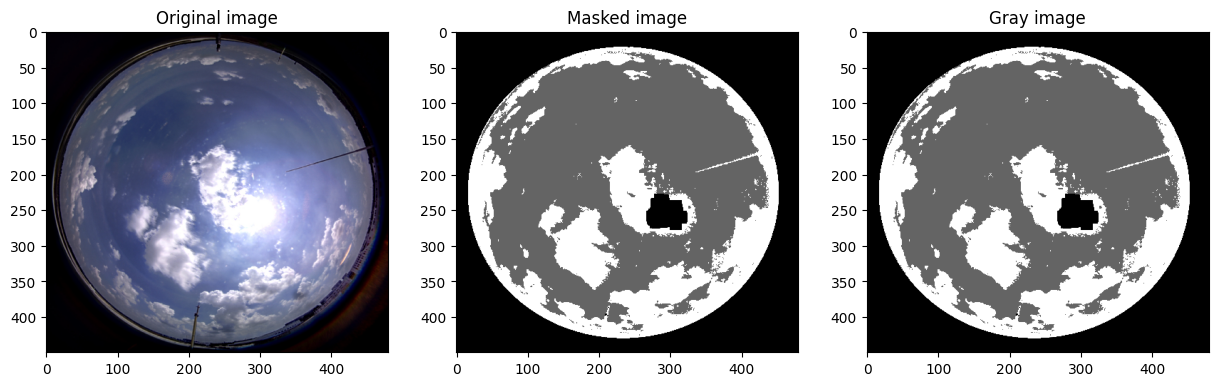

In [5]:
ex_img = cv2.imread("/content/drive/MyDrive/senior/cloud segmentations/WSISEG-Database/whole sky images/ASC100-1006_002")
print("image shape:", ex_img.shape)

mask_ex_img = cv2.imread("/content/drive/MyDrive/senior/cloud segmentations/WSISEG-Database/annotation/ASC100-1006_002")
print("masked shape:", mask_ex_img.shape)

f, (axz1, axz2, axz3) = plt.subplots(1,3, figsize=(15, 15))
axz1.imshow(cv2.cvtColor(ex_img, cv2.COLOR_BGR2RGB))
axz1.title.set_text("Original image")
axz2.imshow(mask_ex_img)
axz2.title.set_text("Masked image")
axz3.imshow(cv2.cvtColor(mask_ex_img, cv2.COLOR_BGR2GRAY), cmap="gray")
axz3.title.set_text("Gray image")
plt.show()

In [ ]:
def crop_resize(image):
  new_image = image[:, 10:460]
  return new_image

In [ ]:
np.unique(mask_ex_img)

array([  0, 100, 255], dtype=uint8)

In [ ]:
resized_image = cv2.resize(mask_ex_img, (224, 224), 0, 0, interpolation = cv2.INTER_NEAREST)
resized_image.shape

(224, 224, 3)

In [ ]:
print(np.unique(np.array(resized_image)))

[  0 100 255]


**remarks:**  These annotation images, cloud, clear sky and undefined area are marked with gray value 255, 100, 0 respectively.

### Data Preparation

In [4]:
SIZE_X = 224
SIZE_Y = 224
n_classes = 3

In [5]:
train_images = []

for file in tqdm(os.listdir(img_path)):
  filename = img_path + file
  img = cv2.imread(filename) # img = cv2.imread(filename, 0)
  img = cv2.resize(img, (SIZE_X, SIZE_Y), 0, 0, interpolation = cv2.INTER_NEAREST)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = img.astype('float32')
  img = img/255.0
  train_images.append(img)

train_images = np.array(train_images)

  0%|          | 0/1600 [00:00<?, ?it/s]

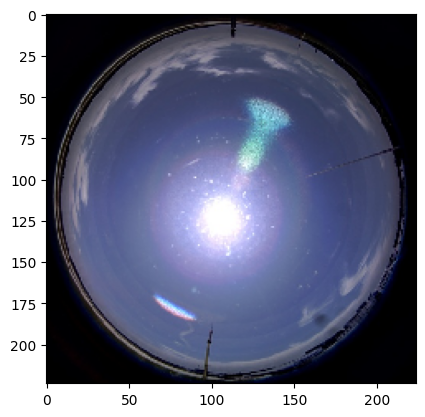

In [8]:
plt.imshow(train_images[0])

In [9]:
train_images[0].max()

1.0

In [ ]:
train_images[0]

In [6]:
train_masks = []

for file in tqdm(os.listdir(mask_path)):
  filename = mask_path + file
  img = cv2.imread(filename)
  img = cv2.resize(img, (SIZE_X, SIZE_Y), 0, 0, interpolation = cv2.INTER_NEAREST)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  train_masks.append(img)
  # print(np.unique(np.array(img)))

train_masks = np.array(train_masks)

  0%|          | 0/1600 [00:00<?, ?it/s]

In [7]:
## Val and Test image
test_images = []

for file in tqdm(sorted(os.listdir(img_val_path))):
    filename = img_val_path + file
    img = cv2.imread(filename)
    img = cv2.resize(img, (SIZE_X, SIZE_Y), 0, 0, interpolation = cv2.INTER_NEAREST)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img/255.0
    test_images.append(img)

test_images = np.array(test_images)

  0%|          | 0/400 [00:00<?, ?it/s]

In [8]:
## Val and Test image
test_masks = []

for file in tqdm(sorted(os.listdir(mask_val_path))):
    filename = mask_val_path + file
    img = cv2.imread(filename)
    img = cv2.resize(img, (SIZE_X, SIZE_Y), 0, 0, interpolation = cv2.INTER_NEAREST)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    test_masks.append(img)

test_masks = np.array(test_masks)

  0%|          | 0/400 [00:00<?, ?it/s]

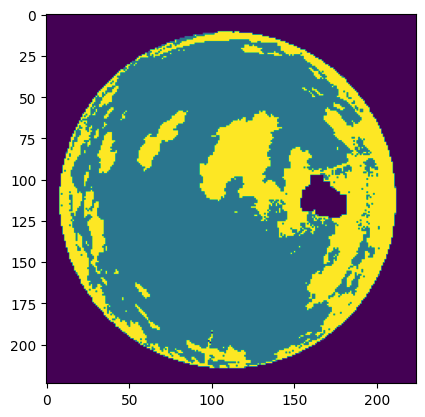

In [15]:
plt.imshow(train_masks[0])

In [9]:
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1, 1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2])

In [10]:
len(np.unique(train_masks_encoded_original_shape))

3

In [11]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

In [12]:
## Val
labelencoder = LabelEncoder()
n, h, w = test_masks.shape
test_masks_reshaped = test_masks.reshape(-1, 1)
test_masks_reshaped_encoded = labelencoder.fit_transform(test_masks_reshaped)
test_masks_encoded_original_shape = test_masks_reshaped_encoded.reshape(n, h, w)

print(np.unique(test_masks_encoded_original_shape))
print(len(np.unique(test_masks_encoded_original_shape)))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0 1 2]
3


In [13]:
test_masks_input = np.expand_dims(test_masks_encoded_original_shape, axis=3)

In [14]:
X_test = test_images
y_test = test_masks_input

#### Train/Test Split

In [15]:
# X_train, X_val, y_train, y_val = train_test_split(train_images, train_masks_input, test_size=0.2, random_state = 0)
# X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.3, random_state = 0)
# print("Class values in the dataset are ...", np.unique(y_val))
X_train, X_val, y_train, y_val = train_test_split(train_images, train_masks_input, test_size=0.2, random_state = 42)

In [16]:
print("Train set:", X_train.shape[0])
print("Validation set:", X_val.shape[0])
print("Test set:", X_test.shape[0])

Train set: 1280
Validation set: 320
Test set: 400


In [17]:
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

In [18]:
val_masks_cat = to_categorical(y_val, num_classes=n_classes)
y_val_cat = val_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))

In [19]:
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [ ]:
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_masks_reshaped_encoded),
                                        y = train_masks_reshaped_encoded                                                    
                                    )
class_weights = dict(zip(np.unique(train_masks_reshaped_encoded), class_weights))
print("Class weights are...:", class_weights)

Class weights are...: {0: 0.932581725544763, 1: 1.1734134255347797, 2: 0.9298058305770954}


In [20]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

print(IMG_HEIGHT)
print(IMG_WIDTH)
print(IMG_CHANNELS)

224
224
3


In [21]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [ ]:
weights = [0.25, 0.25, 0.25]

In [22]:
metrics=['accuracy', jacard_coef]

### Build U-NET multi-class model

In [23]:
def multi_unet_model(n_classes=3, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
    #model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    #model.summary()
    
    return model

#### Get model

In [24]:
def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

#### Compile model

In [25]:
model = get_model()
import tensorflow as tf
opt = tf.keras.optimizers.AdamW(learning_rate=1e-4)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 224, 224, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [26]:
history = model.fit(X_train, y_train_cat, 
                    batch_size = 32, 
                    verbose=1, 
                    epochs=60, 
                    validation_data=(X_val, y_val_cat))

Epoch 1/60
40/40 [==============================] - 25s 122ms/step - loss: 1.0660 - accuracy: 0.3863 - jacard_coef: 0.2157 - val_loss: 0.9775 - val_accuracy: 0.4807 - val_jacard_coef: 0.2393
Epoch 2/60
40/40 [==============================] - 4s 96ms/step - loss: 0.7459 - accuracy: 0.6126 - jacard_coef: 0.3701 - val_loss: 0.7216 - val_accuracy: 0.6274 - val_jacard_coef: 0.3625
Epoch 3/60
40/40 [==============================] - 4s 96ms/step - loss: 0.6013 - accuracy: 0.6726 - jacard_coef: 0.4508 - val_loss: 0.6791 - val_accuracy: 0.6550 - val_jacard_coef: 0.3788
Epoch 4/60
40/40 [==============================] - 4s 96ms/step - loss: 0.5300 - accuracy: 0.7375 - jacard_coef: 0.4862 - val_loss: 0.5838 - val_accuracy: 0.8193 - val_jacard_coef: 0.4305
Epoch 5/60
40/40 [==============================] - 4s 96ms/step - loss: 0.3744 - accuracy: 0.8544 - jacard_coef: 0.6251 - val_loss: 0.4259 - val_accuracy: 0.8560 - val_jacard_coef: 0.5578
Epoch 6/60
40/40 [==============================] - 4

In [28]:
model.save('u-net_Aug2-adw-60-1e-4.h5')

In [27]:
loss, acc, jacard_coef = model.evaluate(X_test, y_test_cat)
print("Loss : ", loss)
print("Accuracy : ", (acc * 100.0), "%")
print("Jacard coef : ", (jacard_coef * 100.0), "%")

13/13 [==============================] - 1s 65ms/step - loss: 0.1488 - accuracy: 0.9530 - jacard_coef: 0.8879
Loss :  0.14880307018756866
Accuracy :  95.29595971107483 %
Jacard coef :  88.78901600837708 %


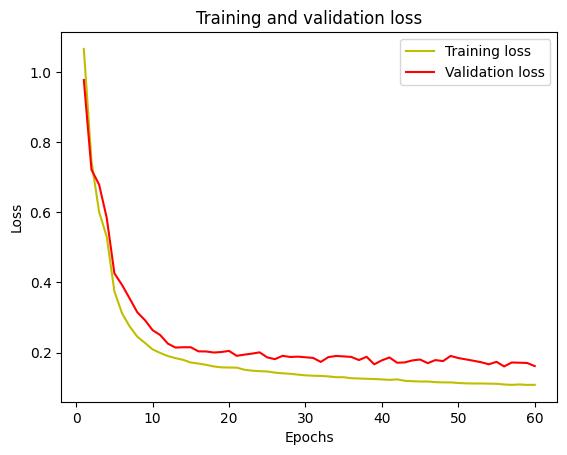

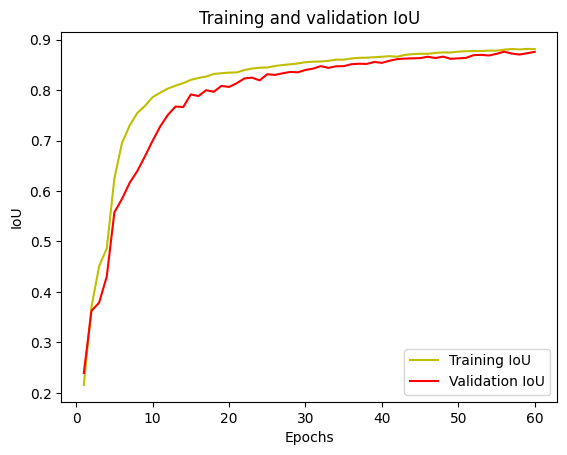

In [29]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [30]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

13/13 [==============================] - 1s 23ms/step


In [31]:
from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.90989774


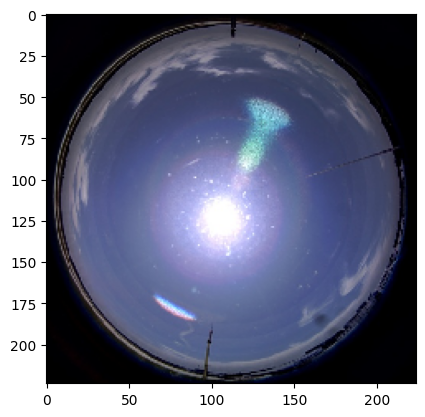

In [31]:
plt.imshow(train_images[0])

In [32]:
import random
test_img_number = random.randint(0, len(X_test))
print("Random index: ",test_img_number)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

Random index:  125
1/1 [==============================] - 0s 223ms/step


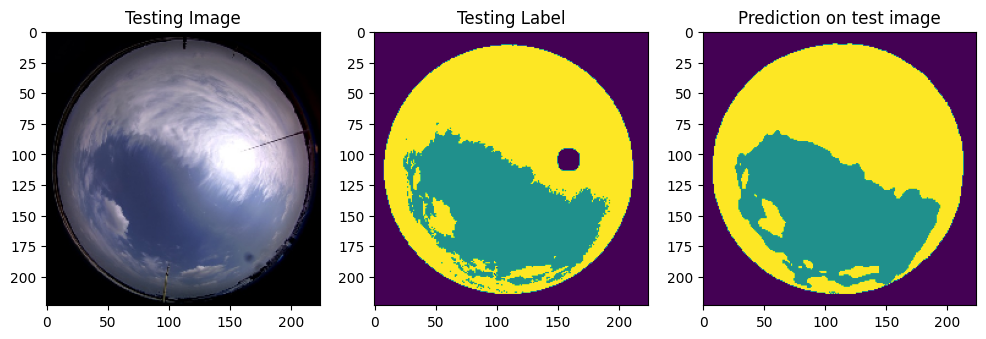

In [33]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

In [ ]:
np.unique(predicted_img)

array([0, 1, 2])

In [ ]:
!nvidia-smi

Thu Mar 30 03:08:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P0    31W /  70W |   5001MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [34]:
def predict(img_path, model):
    image = cv2.imread(img_path)
    # test_local_img = crop_image2(image)
    test_local_img = cv2.resize(image, (224, 224),0,0, interpolation = cv2.INTER_NEAREST)
    test_local_img = cv2.cvtColor(test_local_img, cv2.COLOR_BGR2RGB)
    test_local_img = test_local_img.astype("float32")
    test_local_img = test_local_img/255.0
    masked = test_local_img
    local_test_img_input=np.expand_dims(masked, 0)
    prediction_local = (model.predict(local_test_img_input))
    local_predicted_img=np.argmax(prediction_local, axis=3)[0,:,:]
    return local_predicted_img

In [36]:
pred1 = predict("/content/drive/MyDrive/senior/cloud_dataset/2021_12_09__09_14_00_HDR_cropped.jpg", model)

1/1 [==============================] - 0s 24ms/step


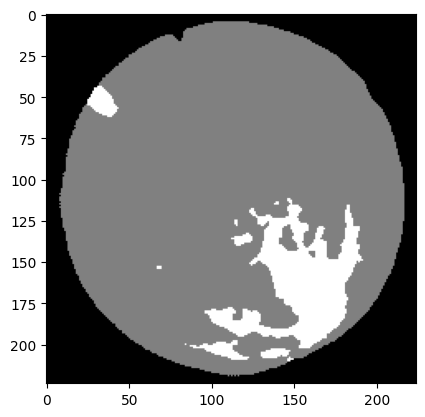

In [37]:
plt.imshow(pred1, cmap='gray')